# Neural Machine Translation in the wild
In this homework you are supposed to get the best translation you can for the EN-RU translation task.

As a baseline, take RNN architecture (LSTM, etc).

Your ultimate task is to use the techniques we've covered, e.g.

* attention/self-attention mechanism

* pretraining the language model

* [Byte Pair Encoding](https://github.com/rsennrich/subword-nmt)

* or just fine-tunning BERT ;)

to improve the translation quality.

**Remember that most of the things you need are in the [Transformers](https://huggingface.co/docs/transformers/index).**

__Please use at least three different approaches/models and compare them (translation quality/complexity/training and evaluation time).__

**You can also use the approaches that you find yourself, if you think that this will improve the quality.**

Write down some summary on your experiments and illustrate it with convergence plots/metrics and your thoughts. Just like you would approach a real problem.

# Recap

![lstm cell](https://habrastorage.org/webt/xt/_q/nj/xt_qnjgfjengqoqd4gizkq4j_wk.png)

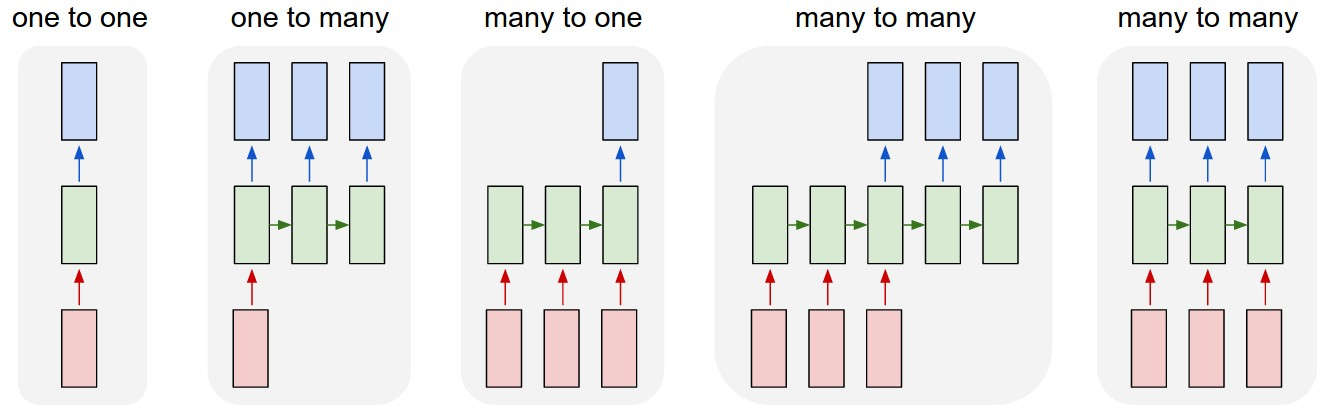

Most competitive neural sequence transduction models have an encoder-decoder structure [(cite)](https://arxiv.org/abs/1409.0473). Here, the encoder maps an input sequence of symbol representations $(x_1, ..., x_n)$ to a sequence of continuous representations $\mathbf{z} = (z_1, ..., z_n)$. Given $\mathbf{z}$, the decoder then generates an output sequence $(y_1,...,y_m)$ of symbols one element at a time. At each step the model is auto-regressive [(cite)](https://arxiv.org/abs/1308.0850), consuming the previously generated symbols as additional input when generating the next.

![alt text](https://raw.githubusercontent.com/harvardnlp/annotated-transformer/master/images/ModalNet-21.png)

### Attention
An attention function can be described as mapping a query and a set of key-value pairs to an output, where the query, keys, values, and output are all vectors.  The output is computed as a weighted sum of the values, where the weight assigned to each value is computed by a compatibility function of the query with the corresponding key.

We call our particular attention 'Scaled Dot-Product Attention'.   The input consists of queries and keys of dimension $d_k$, and values of dimension $d_v$.  We compute the dot products of the query with all keys, divide each by $\sqrt{d_k}$, and apply a softmax function to obtain the weights on the values.


![alt text](https://raw.githubusercontent.com/harvardnlp/annotated-transformer/master/images/ModalNet-19.png)


In practice, we compute the attention function on a set of queries simultaneously, packed together into a matrix $Q$.   The keys and values are also packed together into matrices $K$ and $V$.  We compute the matrix of outputs as:

$$
   \mathrm{Attention}(Q, K, V) = \mathrm{softmax}(\frac{QK^T}{\sqrt{d_k}})V
$$

## Byte-pair-encoding

A simple data compression algorithm first [introduced in 1994](https://www.derczynski.com/papers/archive/BPE_Gage.pdf). It was later reintroudiced for NLP to the task of word segmentation in [this article](https://arxiv.org/pdf/1508.07909.pdf). BPE allows for the
representation of an open vocabulary through
a fixed-size vocabulary of variable-length
character sequences, making it a very suitable word segmentation strategy for neural
network models.

The code below shows a toy example of learned BPE
operations. At test time, we first split words into
sequences of characters, then apply the learned operations to merge the characters into larger, known
symbols. This is applicable to any word, and
allows for open-vocabulary networks with fixed
symbol vocabularies.
In our example, the
‘lower’ would be segmented into ‘low er·’

![alt text](https://alexanderdyakonov.files.wordpress.com/2019/11/bpe.jpg)

Source: [Subword Tokenization](https://dyakonov.org/2019/11/29/%D1%82%D0%BE%D0%BA%D0%B5%D0%BD%D0%B8%D0%B7%D0%B0%D1%86%D0%B8%D1%8F-%D0%BD%D0%B0-%D0%BF%D0%BE%D0%B4%D1%81%D0%BB%D0%BE%D0%B2%D0%B0-subword-tokenization/)


#### 1. **Load and Preprocess Data, Prepare a Tokenizer**
For each approach, you will need to tokenize the data. For the basic RNN model, you can use a simple tokenizer.
For models like BERT, use the appropriate tokenizer (e.g., AutoTokenizer.from_pretrained('bert-base-uncased')).

*Your dataset is in the sentence-translation format.*

> Cordelia Hotel is situated in Tbilisi, a 3-minute walk away from Saint Trinity Church.

> Отель Cordelia расположен в Тбилиси, в 3 минутах ходьбы от Свято-Троицкого собора.

#### 2. **Build an RNN Model with LSTM, train and Evaluate the Model.**
#### 3. **Improve!** (You can use Byte Pair Encoding (BPE), Attention Mechanism, Pretrained Model, etc. Just turn on your imagination🤩)

#### 4. **Comparison and Conclusions** (Analyze the Results and Write a Report.)


You can use this code to implement the baseline.

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim

import random
import math
import time


class Encoder(nn.Module):
    def __init__(self, input_dim, emb_dim, hid_dim, n_layers, dropout):
        super().__init__()

        self.input_dim = input_dim
        self.emb_dim = emb_dim
        self.hid_dim = hid_dim
        self.n_layers = n_layers
        self.dropout = dropout

        self.embedding = nn.Embedding(
            num_embeddings=input_dim,
            embedding_dim=emb_dim
        )

        self.rnn = nn.LSTM(
            input_size=emb_dim,
            hidden_size=hid_dim,
            num_layers=n_layers,
            dropout=dropout
        )

        self.dropout = nn.Dropout(p=dropout)

    def forward(self, src):
        # Compute an embedding from the src data and apply dropout to it
        embedded = self.embedding(src)

        embedded = self.dropout(embedded)

        output, (hidden, cell) = self.rnn(embedded)
        # embedded = [src sent len, batch size, emb dim]

        # Compute the RNN output values of the encoder RNN.
        # outputs, hidden and cell should be initialized here. Refer to nn.LSTM docs ;)

        # outputs = [src sent len, batch size, hid dim * n directions]
        # hidden = [n layers * n directions, batch size, hid dim]
        # cell = [n layers * n directions, batch size, hid dim]

        # outputs are always from the top hidden layer

        return hidden, cell


class Decoder(nn.Module):
    def __init__(self, output_dim, emb_dim, hid_dim, n_layers, dropout):
        super().__init__()

        self.emb_dim = emb_dim
        self.hid_dim = hid_dim
        self.output_dim = output_dim
        self.n_layers = n_layers
        self.dropout = dropout

        self.embedding = nn.Embedding(
            num_embeddings=output_dim,
            embedding_dim=emb_dim
        )

        self.rnn = nn.LSTM(
            input_size=emb_dim,
            hidden_size=hid_dim,
            num_layers=n_layers,
            dropout=dropout
        )

        self.out = nn.Linear(
            in_features=hid_dim,
            out_features=output_dim
        )

        self.dropout = nn.Dropout(p=dropout)

    def forward(self, input, hidden, cell):

        #input = [batch size]
        #hidden = [n layers * n directions, batch size, hid dim]
        #cell = [n layers * n directions, batch size, hid dim]

        #n directions in the decoder will both always be 1, therefore:
        #hidden = [n layers, batch size, hid dim]
        #context = [n layers, batch size, hid dim]

        input = input.unsqueeze(0)

        #input = [1, batch size]

        # Compute an embedding from the input data and apply dropout to it
        embedded = self.dropout(self.embedding(input))# <YOUR CODE HERE>

        #embedded = [1, batch size, emb dim]

        # Compute the RNN output values of the encoder RNN.
        # outputs, hidden and cell should be initialized here. Refer to nn.LSTM docs ;)


        #output = [sent len, batch size, hid dim * n directions]
        #hidden = [n layers * n directions, batch size, hid dim]
        #cell = [n layers * n directions, batch size, hid dim]

        #sent len and n directions will always be 1 in the decoder, therefore:
        #output = [1, batch size, hid dim]
        #hidden = [n layers, batch size, hid dim]
        #cell = [n layers, batch size, hid dim]


        output, (hidden, cell) = self.rnn(embedded, (hidden, cell))
        prediction = self.out(output.squeeze(0))

        #prediction = [batch size, output dim]

        return prediction, hidden, cell


class Seq2Seq(nn.Module):
    def __init__(self, encoder, decoder, device):
        super().__init__()

        self.encoder = encoder
        self.decoder = decoder
        self.device = device

        assert encoder.hid_dim == decoder.hid_dim, \
            'Hidden dimensions of encoder and decoder must be equal!'
        assert encoder.n_layers == decoder.n_layers, \
            'Encoder and decoder must have equal number of layers!'

    def forward(self, src, trg, teacher_forcing_ratio = 0.5):

        #src = [src sent len, batch size]
        #trg = [trg sent len, batch size]
        #teacher_forcing_ratio is probability to use teacher forcing
        #e.g. if teacher_forcing_ratio is 0.75 we use ground-truth inputs 75% of the time

        # Again, now batch is the first dimention instead of zero
        batch_size = trg.shape[1]
        max_len = trg.shape[0]
        trg_vocab_size = self.decoder.output_dim

        #tensor to store decoder outputs
        outputs = torch.zeros(max_len, batch_size, trg_vocab_size).to(self.device)

        #last hidden state of the encoder is used as the initial hidden state of the decoder
        hidden, cell = self.encoder(src)

        #first input to the decoder is the <sos> tokens
        input = trg[0,:]

        for t in range(1, max_len):

            output, hidden, cell = self.decoder(input, hidden, cell)
            outputs[t] = output
            teacher_force = random.random() < teacher_forcing_ratio
            top1 = output.max(1)[1]
            input = (trg[t] if teacher_force else top1)

        return outputs


A module that was compiled using NumPy 1.x cannot be run in
NumPy 2.0.2 as it may crash. To support both 1.x and 2.x
versions of NumPy, modules must be compiled with NumPy 2.0.
Some module may need to rebuild instead e.g. with 'pybind11>=2.12'.

If you are a user of the module, the easiest solution will be to
downgrade to 'numpy<2' or try to upgrade the affected module.
We expect that some modules will need time to support NumPy 2.

Traceback (most recent call last):  File "<frozen runpy>", line 198, in _run_module_as_main
  File "<frozen runpy>", line 88, in _run_code
  File "/home/denis/miniconda3/lib/python3.12/site-packages/ipykernel_launcher.py", line 18, in <module>
    app.launch_new_instance()
  File "/home/denis/miniconda3/lib/python3.12/site-packages/traitlets/config/application.py", line 1075, in launch_instance
    app.start()
  File "/home/denis/miniconda3/lib/python3.12/site-packages/ipykernel/kernelapp.py", line 739, in start
    self.io_loop.start()
  File "/home/denis

In [2]:
# Thanks to YSDA NLP course team for the data
# (who thanks tilda and deephack teams for the data in their turn)

import os
path_do_data = '../../datasets/Machine_translation_EN_RU/data.txt'
if not os.path.exists(path_do_data):
    print('Dataset not found locally. Downloading from github. Loading special files as well')
    !wget https://raw.githubusercontent.com/9OMShitikov/ml-mipt/master/datasets/Machine_translation_EN_RU/data.txt -nc
    path_do_data = './data.txt'


Dataset not found locally. Downloading from github. Loading special files as well
File ‘data.txt’ already there; not retrieving.



Baseline solution BLEU score is quite low. Try to achieve at least __24__ BLEU on the test set.
The checkpoints are:

* __22__ - minimal score to submit the homework, 30% of points

* __27__ - good score, 70% of points

* __29__ - excellent score, 100% of points

The more approaches you try and describe the result qualitatively, the higher your score will be.

# My Solutions

## Read Data

In [3]:
import pandas as pd 
from sklearn.model_selection import train_test_split

df = pd.read_csv('data.txt', sep='\t', names=['source', 'target'])
train_df, test_df = train_test_split(df, test_size=0.2, random_state=42)

df.head()

,source,target
0,"Cordelia Hotel is situated in Tbilisi, a 3-min...","Отель Cordelia расположен в Тбилиси, в 3 минут..."
1,At Tupirmarka Lodge you will find a 24-hour fr...,В числе удобств лоджа Tupirmarka круглосуточна...
2,"Featuring free WiFi in all areas, Naigao Xiaow...",Апартаменты Naigao Xiaowo расположены в городе...
3,Each has a TV and a private bathroom with shower.,В вашем распоряжении также телевизор и собстве...
4,Your room comes with air conditioning and sate...,Номер оснащен кондиционером и спутниковым теле...


In [4]:
train_df.reset_index(drop=True, inplace=True)
test_df.reset_index(drop=True, inplace=True)

In [5]:
import spacy

In [6]:
en_nlp = spacy.load('en_core_web_sm')
ru_nlp = spacy.load('ru_core_news_sm')

In [7]:
def tokenize_text(text, tokenizer, sos_token, eos_token, max_length, lower):
    
    tokens = [token.text for token in tokenizer.tokenizer(text)][:max_length]
    
    if lower:
        tokens = [token.lower() for token in tokens]

    tokens = [sos_token] + tokens + [eos_token]

    return tokens

In [8]:
# Параметры токенизации
max_length = 1_000
lower = True
sos_token = '<sos>'
eos_token = '<eos>'

# Параметры для передачи в токенизирующую функцию
en_kwargs = {
    'tokenizer': en_nlp,
    'max_length': max_length,
    'lower': lower,
    'sos_token': sos_token,
    'eos_token': eos_token,
}

ru_kwargs = {
    'tokenizer': ru_nlp,
    'max_length': max_length,
    'lower': lower,
    'sos_token': sos_token,
    'eos_token': eos_token,
}


In [9]:
test_df['source_tokens'] = test_df['source'].apply(tokenize_text, **en_kwargs)
test_df['target_tokens'] = test_df['target'].apply(tokenize_text, **ru_kwargs)

train_df['source_tokens'] = train_df['source'].apply(tokenize_text, **en_kwargs)
train_df['target_tokens'] = train_df['target'].apply(tokenize_text, **ru_kwargs)

In [10]:
import collections

def build_vocab_from_iterator(iterator, specials=['<unk>', '<pad>', '<bos>', '<eos>'], min_freq=1):
    counter = collections.Counter()
    
    # Count the frequency of each token
    for tokens in iterator:
        counter.update(tokens)
    
    # Create a vocabulary dictionary with special tokens
    vocab = {token: idx for idx, token in enumerate(specials)}
    
    # Add tokens to the vocabulary based on their frequency
    for token, freq in counter.items():
        if freq >= min_freq:
            vocab[token] = len(vocab)
    
    return vocab

In [11]:
s_vocab = build_vocab_from_iterator(train_df['source_tokens'])
t_vocab = build_vocab_from_iterator(train_df['target_tokens'])

In [12]:
unk_token = '<unk>'
pad_token = '<pad>'

assert s_vocab[unk_token] == t_vocab[unk_token]
assert s_vocab[pad_token] == t_vocab[pad_token]

unk_index = s_vocab[unk_token]
pad_index = t_vocab[pad_token]

In [13]:
train_df['source_ids'] = train_df['source_tokens'].apply(lambda x: [s_vocab[token] for token in x])
train_df['target_ids'] = train_df['target_tokens'].apply(lambda x: [t_vocab[token] for token in x])

In [14]:
test_df['source_ids'] = test_df['source_tokens'].apply(lambda x: [s_vocab[token] if token in s_vocab else unk_index for token in x])
test_df['target_ids'] = test_df['target_tokens'].apply(lambda x: [t_vocab[token] if token in t_vocab else unk_index for token in x])

In [15]:
def get_collate_fn(pad_index):
    def collate_fn(batch):
        batch_en_ids = [torch.tensor(example['source_ids']) for example in batch]
        batch_de_ids = [torch.tensor(example['target_ids']) for example in batch]
        batch_en_ids = nn.utils.rnn.pad_sequence(batch_en_ids, padding_value=pad_index)
        batch_de_ids = nn.utils.rnn.pad_sequence(batch_de_ids, padding_value=pad_index)
        batch = {
            'source_ids': batch_en_ids,
            'target_ids': batch_de_ids,
        }
        return batch

    return collate_fn

In [16]:
def get_data_loader(dataset, batch_size, pad_index, shuffle=False):
    collate_fn = get_collate_fn(pad_index)
    data_loader = torch.utils.data.DataLoader(
        dataset=dataset,
        batch_size=batch_size,
        collate_fn=collate_fn,
        shuffle=shuffle,
    )
    return data_loader

In [17]:
from torch.utils.data import Dataset

class PandasDataset(Dataset):
    def __init__(self, dataframe):
        self.dataframe = dataframe

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, index):
        return self.dataframe.iloc[index]

In [18]:
train_ds = PandasDataset(train_df)
test_ds = PandasDataset(test_df)

In [19]:
batch_size = 64

train_data_loader = get_data_loader(train_ds, batch_size, pad_index, shuffle=True)
test_data_loader = get_data_loader(test_ds, batch_size, pad_index)

In [20]:
input_dim = len(s_vocab)
output_dim = len(t_vocab)
enc_emb_dim = 256
dec_emb_dim = 256
hid_dim = 512
n_layers = 2
enc_dropout = 0.5
dec_dropout = 0.5
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

encoder = Encoder(input_dim, enc_emb_dim, hid_dim, n_layers, enc_dropout)
decoder = Decoder(output_dim, dec_emb_dim, hid_dim, n_layers, dec_dropout)

model = Seq2Seq(encoder, decoder, device).to(device)

In [21]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)


print(f'The model has {count_parameters(model):,} trainable parameters')

The model has 44,917,432 trainable parameters


In [22]:
optimizer = optim.Adam(model.parameters())

In [23]:
from tqdm.auto import tqdm as tqdma

/home/denis/miniconda3/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [24]:
def train_fn(
    model, data_loader, optimizer, criterion, clip, teacher_forcing_ratio, device
):
    model.train()
    epoch_loss = 0
    for i, batch in tqdma(enumerate(data_loader)):
        src = batch['source_ids'].to(device)
        trg = batch['target_ids'].to(device)
        # src = [src length, batch size]
        # trg = [trg length, batch size]
        optimizer.zero_grad()
        output = model(src, trg, teacher_forcing_ratio)
        # output = [trg length, batch size, trg vocab size]
        output_dim = output.shape[-1]
        output = output[1:].view(-1, output_dim)
        # output = [(trg length - 1) * batch size, trg vocab size]
        trg = trg[1:].view(-1)
        # trg = [(trg length - 1) * batch size]
        loss = criterion(output, trg)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), clip)
        optimizer.step()
        epoch_loss += loss.item()
    return epoch_loss / len(data_loader)

In [25]:
def evaluate_fn(model, data_loader, criterion, device):
    model.eval()
    epoch_loss = 0
    with torch.no_grad():
        for i, batch in enumerate(data_loader):
            src = batch["de_ids"].to(device)
            trg = batch["en_ids"].to(device)
            # src = [src length, batch size]
            # trg = [trg length, batch size]
            output = model(src, trg, 0)  # turn off teacher forcing
            # output = [trg length, batch size, trg vocab size]
            output_dim = output.shape[-1]
            output = output[1:].view(-1, output_dim)
            # output = [(trg length - 1) * batch size, trg vocab size]
            trg = trg[1:].view(-1)
            # trg = [(trg length - 1) * batch size]
            loss = criterion(output, trg)
            epoch_loss += loss.item()
    return epoch_loss / len(data_loader)

In [26]:
import numpy as np

In [ ]:
n_epochs = 1
clip = 1.0
teacher_forcing_ratio = 0.5

best_valid_loss = float("inf")
criterion = nn.CrossEntropyLoss(ignore_index=pad_index)


for epoch in tqdma(range(n_epochs)):
    
    train_loss = train_fn(
        model,
        train_data_loader,
        optimizer,
        criterion,
        clip,
        teacher_forcing_ratio,
        device,
    )

    test_loss = evaluate_fn(
        model,
        test_data_loader,
        criterion,
        device,
    )
    if test_loss < best_valid_loss:
        best_valid_loss = test_loss
        torch.save(model.state_dict(), "tut3-model.pt")
    print(f"\tTrain Loss: {train_loss:7.3f} | Train PPL: {np.exp(train_loss):7.3f}")
    print(f"\tValid Loss: {test_loss:7.3f} | Valid PPL: {np.exp(test_loss):7.3f}")

  0%|          | 0/1 [00:00<?, ?it/s]